<img src="https://github.com/gantian127/pymt_nwis/blob/master/docs/_static/logo.png?raw=true" width='600' align='center'></a>

## Basic Info
This Jupyter Notebook was created by Tian Gan. You can run this Jupyter Notebook through [HydroShare](https://www.hydroshare.org/resource/1473ac1368b44808b57cca2848923779/).

If you have any question or suggestion to improve the current functions of the pymt_nwis package, please create a github issue [here](https://github.com/gantian127/pymt_nwis/issues).

Suggested citation: Gan, T. (2022). Jupyter Notebooks for the NWIS Data Component, HydroShare, https://www.hydroshare.org/resource/1473ac1368b44808b57cca2848923779/

## Introduction

[pymt_nwis](https://github.com/gantian127/pymt_nwis) is a package that uses the [bmi_nwis](https://github.com/gantian127/bmi_nwis) pacakge to convert NWIS datasets into a reusable, plug-and-play data component for [PyMT](https://pymt.readthedocs.io/en/latest/?badge=latest) modeling framework developed by Community Surface Dynamics Modeling System ([CSDMS](https://csdms.colorado.edu/wiki/Main_Page)). This allows NWIS datasets to be easily coupled with other datasets or models that expose a Basic Model Interface ([BMI](https://bmi-spec.readthedocs.io/en/latest/)).

### Install pymt
If you run this notebook on [HydroShare](https://www.hydroshare.org/resource/1473ac1368b44808b57cca2848923779/), please skip this step. Otherwise, please follow the [instructions](https://github.com/gantian127/pymt_nwis/blob/master/README.rst) to create a separate environment and install pymt.

### Install pymt_nwis

You can use the following command to install pymt_nwis:

In [ ]:
! pip install pymt_nwis

## Coding Example

Import Nwis class and instantiate it. A configuration file (yaml file) is required to provide the parameter settings for data download. An example [config_file.yaml](https://github.com/gantian127/pymt_nwis/blob/master/notebooks/config_file.yaml) is provided in the same folder with this Jupyter Notebook file. For more details of the parameters specified in the config.yaml file, please check with the link [here](https://bmi_nwis.readthedocs.io/en/latest/?badge=latest#parameter-settings).

In [1]:
import numpy as np
import cftime
import pandas as pd

from pymt.models import Nwis

# initiate a data component
data_comp = Nwis()
data_comp.initialize('config_file.yaml')

Use variable related methods to check the variable information of the NWIS data. You will find out that there are multiple variables for this dataset.

In [2]:
# get variable info
for var_name in data_comp.output_var_names:
    var_unit = data_comp.var_units(var_name)
    var_location = data_comp.var_location(var_name)
    var_type = data_comp.var_type(var_name)
    var_grid = data_comp.var_grid(var_name)
    var_itemsize = data_comp.var_itemsize(var_name)
    var_nbytes = data_comp.var_nbytes(var_name)

    print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}'
        '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: Stream flow 
var_unit: ft3/s 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Inorganic nitrogen (nitrate and nitrite) 
var_unit: mg/l as N 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Turbidity 
var_unit: FNU 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 

variable_name: Height 
var_unit: ft 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 8
var_nbytes: 8 



Use time related methods to check the time information of the dataset. Please note that the time values are stored in a format which follows [CF convention](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.pdf).

In [3]:
# get time info
start_time = data_comp.start_time
end_time = data_comp.end_time
time_step = data_comp.time_step
time_units = data_comp.time_units
time_steps = int((end_time - start_time)/time_step) + 1

print('start_time: {} \nend_time: {} \ntime_step: {} \ntime_units: {} \ntime_steps: {}'.format(
    start_time, end_time, time_step, time_units, time_steps))

start_time: 1641016800.0 
end_time: 1641275100.0 
time_step: 900.0 
time_units: seconds since 1970-01-01 00:00:00 UTC 
time_steps: 288


Loop through each time step to get the stream flow, gage height and time values. get_value( ) method returns the stream flow (parameter code as 00060) and gage height (parameter code as 00065) values at each time step. update( ) method updates the current time step of the data component.

In [4]:
# initiate dataframe to store data
dataset = pd.DataFrame(columns = ['00060','00065','time'])

for i in range(0, time_steps):  
    # get values
    stream_flow = data_comp.get_value('Stream flow')
    gage_height = data_comp.get_value('Height')
    time = cftime.num2pydate(data_comp.time, time_units)
    
    # add new row to dataframe
    dataset.loc[len(dataset)]=[stream_flow[0], gage_height[0], time]
    
    # update to next time step
    data_comp.update()
    
# convert time to local time
dataset = dataset.set_index('time').tz_localize(tz='UTC').tz_convert(tz='US/Central')

Now let's make a plot of the stream flow and gage height data. 

Text(0, 0.5, 'Gage height (ft)')

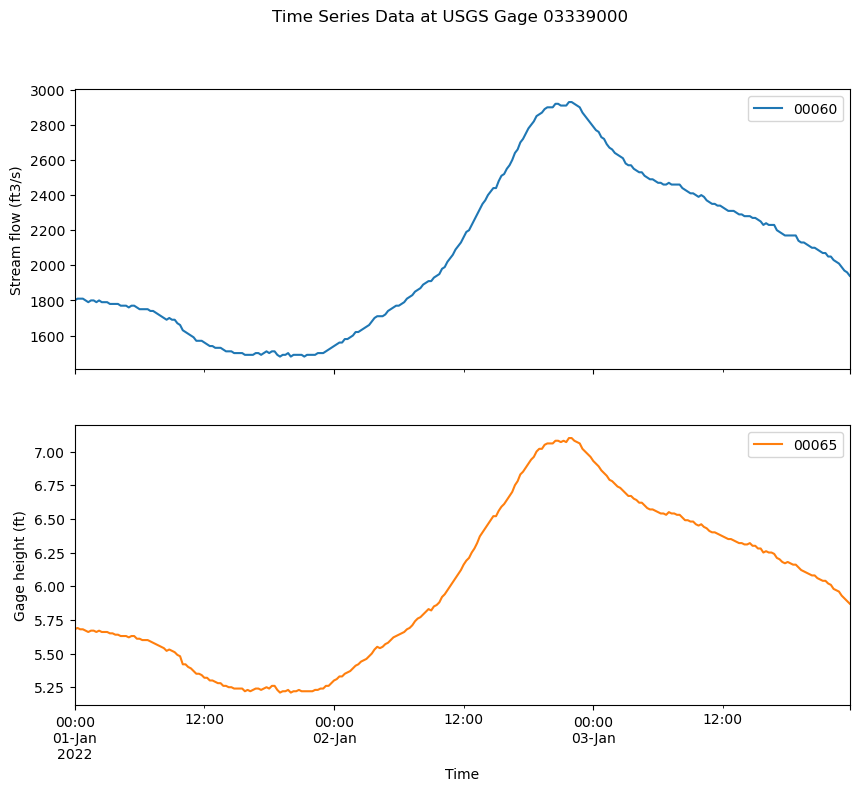

In [5]:
# plot data
ax = dataset.plot(y=['00060','00065'], subplots=True, figsize=(10,8), 
                  xlabel='Time', title = 'Time Series Data at USGS Gage 03339000')
ax[0].set_ylabel('Stream flow (ft3/s)')
ax[1].set_ylabel('Gage height (ft)')

Complete the example by finalizing the component. finalize( ) method performs tasks that take place after using the data component, such as deallocating memory and closing files.

In [6]:
data_comp.finalize()